In [1]:
from ss2hcsp.hcsp.simulator import HCSPInfo, exec_parallel, graph

# HCSP简介

混成通讯顺序进程(Hybrid Communicating Sequential Processes, HCSP)是一个形式化建模语言，在通讯顺序进程(CSP)语言的基础上添加了由微分方程描述的连续演化和中断机制。在```ss2hcsp.hcsp.simulator```中提供了对HCSP进程的仿真功能。首先，我们定义一个简单的wrapper来调用仿真函数。

In [2]:
def run_processes(infos, num_io_events):
    list_infos = []
    for name, ps in infos.items():
        list_infos.append(HCSPInfo(name, ps))
    res = exec_parallel(list_infos, num_io_events=num_io_events)
    events = [event['str'] for event in res['trace'] if event['str'] not in ('start', 'step')]
    return res, events

## 赋值和循环

首先，我们考虑一些单线程的例子。在HCSP中，wait(n)的含义是等待n秒（或其他时间单位）。一个简单的程序如下：

In [3]:
res, events = run_processes({
    'P0': "x := 1; wait(1); x := 0; wait(2); x := 2; wait(1)"
}, 10)

```run_processes```接收一个从进程名称到进程代码的字典，并返回两个值：
1. ```res```包含了所有运行时的信息，可以通过```graph```函数画出每个进程变量的变化轨迹。
2. ```events```包含了运行进程时发生的事件。

首先，我们看一下graph的给出期望的结果：

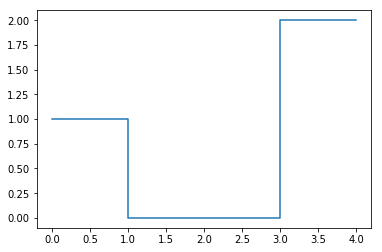

In [4]:
graph(res, 'P0')

对于这个例子，```events```记录了在执行过程中分别暂停了1，2，1秒：

In [5]:
events

['delay 1', 'delay 2', 'delay 1', 'deadlock']

下面，我们展示赋值和循环的使用。以下进程将$x$初始化为0，然后不断对$x$加2并等待1秒：

In [6]:
res, events = run_processes({
    'P0': "x := 0; (x := x + 2; wait(1))**"
}, 10)

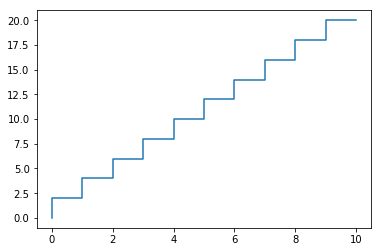

In [7]:
graph(res, 'P0')

## 微分方程

下面，我们展示微分方程的使用。一个微分方程构造$\langle \dot{x} = e \& B\rangle$表示：根据$x$的导数为$e$演化，直到系统状态离开由$B$指定的区域。例如，

In [8]:
res, events = run_processes({
    'P0': "x := 0; <x_dot = 2 & x < 10>"
}, 10)

该进程从$x$从0开始，以速度2上升，直到到达$x=10$。因此，该进程的执行时间应该为5秒钟：

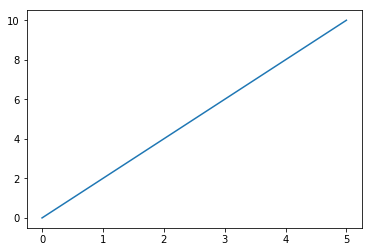

In [9]:
graph(res, 'P0')

```events```列表仅记录等待的时间：

In [10]:
events

['delay 5.0', 'deadlock']

合并循环和微分方程，我们可以构造一个具有锯齿形状演化的系统：

In [11]:
res, events = run_processes({
    'P0': "x := 0; (<x_dot = 1 & x < 1>; <x_dot = -1 & x > 0>)**"
}, 10)

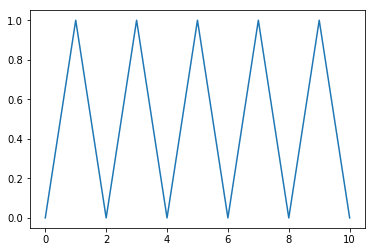

In [12]:
graph(res, 'P0')

微分方程可能有各种形式。例如，以下微分方程的行为是指数增长：

In [13]:
res, events = run_processes({
    'P0': "x := 1; <x_dot = 0.2*x & x < 3>"
}, 10)

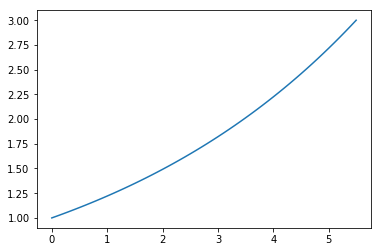

In [14]:
graph(res, 'P0')

我们可以在```res['times']```中读出整个仿真时间（在这里就是$x$到达3需要的时间）：

In [15]:
res['time']

5.493046902196262

此外，微分方程还允许多个变量同时变化。以下例子描述了加速度为常数的模型，在对汽车、列车等系统的建模时非常常见：

In [16]:
res, events = run_processes({
    'P0': "x := 0; v := 0; a := 1; <x_dot = v, v_dot = a & x < 10>"
}, 10)

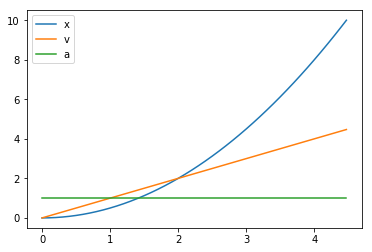

In [18]:
graph(res, 'P0', separate=False)

在该图中，同时展示了$x, v$和$a$随着时间的演变。我们也可以省略```separate=False```选项，使得```graph```函数输出3个图。

下面的例子建模一个旋转行为的系统。注意，我们使用$t$变量来控制执行时间：

In [31]:
res, events = run_processes({
    'P0': "x := 1; y := 0; t := 0; <x_dot = y, y_dot = -x, t_dot = 1 & t < 6.283>"
}, 10)

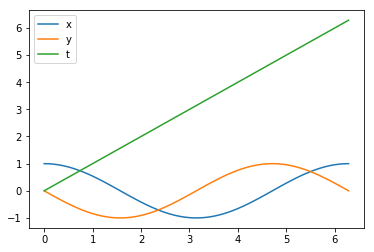

In [32]:
graph(res, 'P0', separate=False)

## 通讯

CSP最显著的特征是允许多个进程以及进程之间的通讯。两个进程之间可以通过一个通道传递信息。设通道的名称为$ch$，那么$ch!e$表示将表达式$e$的值从通道$ch$发出，$ch?x$表示从通道$ch$接收一个值，并将其存在变量$x$中。CSP中的通信是*同步*的，意味着通信的双方都必须准备好才能够通信。如果一方没有准备好，另一方进入等待状态。我们先看一个简单的例子：

In [43]:
res, events = run_processes({
    'P0': "x := 2; wait(1); ch!x; wait(1)",
    'P1': "y := 0; ch?y; wait(1)"
}, 10)

这个并发进程的执行如下：首先P0将$x$的值初始化为2，P1将$y$的值初始化为0。然后P1可以从通道$ch$接收信息。但是，此时P0还不能发送信息。在P0等待一秒钟之后，从$ch$发送$x$的值（也就是2）。这是通信发生，P1接收到2并将其存放在变量$y$中。因此P1里$y$的演化如下：

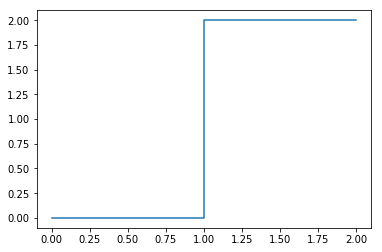

In [44]:
graph(res, 'P1')

```events```列表记录了等待和通信的过程：

In [45]:
events

['delay 1', 'IO ch 2', 'delay 1', 'deadlock']

下面的例子在P0计数，并将每个数的平方传输给P1：

In [48]:
res, events = run_processes({
    'P0': "x := 0; (x := x + 1; ch!x*x; wait(1))**",
    'P1': "(ch?y)**"
}, 10)

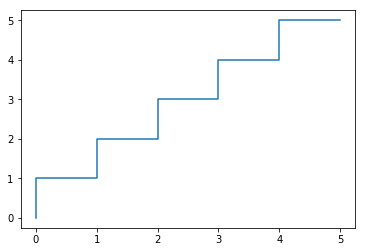

In [49]:
graph(res, 'P0')

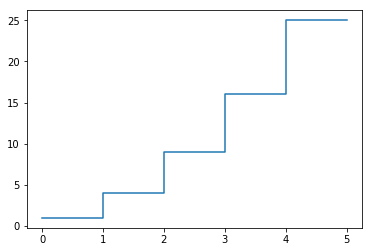

In [50]:
graph(res, 'P1')

In [52]:
events

['IO ch 1',
 'delay 1',
 'IO ch 4',
 'delay 1',
 'IO ch 9',
 'delay 1',
 'IO ch 16',
 'delay 1',
 'IO ch 25',
 'delay 1']

通过结合微分方程、通信和循环，我们已经能够对一些简单控制策略进行建模。以下展示了一个基本的例子。第一个进程代表被控制的物理过程(plant)，第二个进程代表控制策略(control)。每当$x$大于$0.5$时，将速度设为$-1$。每当$x$小于$0.5$时，将速度设为1。这保证了$x$的值能够稳定在$0.5$周围。注意$t$的使用，保证每0.05秒进行一次控制。

In [56]:
res, events = run_processes({
    'P0': "x := 0; v := 1; (t := 0; <x_dot = v, t_dot = 1 & t < 0.05>; p2c!x; c2p?v)**",
    'P1': "(p2c?x; x > 0.5 -> c2p!-1; x <= 0.5 -> c2p!1)**"
}, 100)

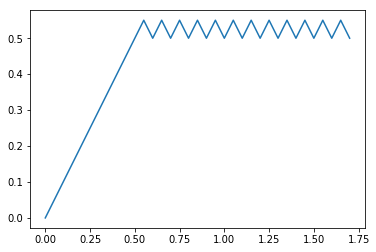

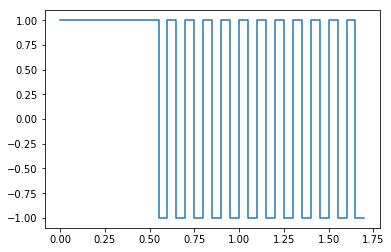

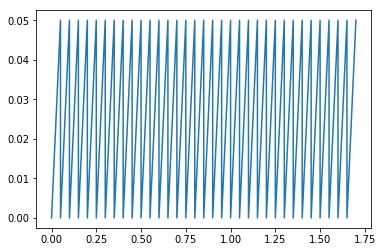

In [58]:
graph(res, 'P0')

## 中断

在这个例子中，第一个进程将$x$初始化为0之后，设$x$的导数为1，然后等待从p2c通道发送$x$的值。从p2c通道发送通信之后，等待从c2p通道接收新的$x$的值。第二个进程等待1秒之后从p2c通道接收通信，并把接收的值存在$x$中，然后发送$x-1$的值。因此这两个进程的并发执行应该为每一秒钟在p2c传递1，然后紧接着在c2p传递0。

In [ ]:
res, events = run_processes({
    'P0': "x := 0; v := 1; (t := 0; <x_dot = v, t_dot = 1 & t < 0.05>; p2c!x; c2p?v)**",
    'P1': "(p2c?x; x > 0.5 -> c2p!-1; x <= 0.5 -> c2p!1)**"
}, 100)infos = [
]

In [ ]:
for i in range(len(infos)):
    infos[i] = HCSPInfo('P' + str(i), infos[i])

In [ ]:
trace

In [ ]:
graph(res, 'P0')